# Vision Language Model (VLM) Integration with ROS 2

In this notebook, we'll integrate Vision Language Models with ROS 2, demonstrating how to build intelligent vision nodes that can understand and describe what robots see. 

By combining VLM capabilities with ROS 2's robust communication infrastructure, we can create powerful perception pipelines for autonomous robots, enabling natural language interaction with visual scenes.

While in the NPU section we showed how to integrate hardware acceleration in a Publisher/Subscriber pipeline, here we will set up a VLM service node.

## Goals

* Understand the llama.cpp OpenAI-compatible API
* Integrate a local VLM as a service node using ROS 2 Python RCL
* Build a complete vision-language pipeline using ROS 2

## References

* [Understanding ROS 2 Services](https://docs.ros.org/en/kilted/Tutorials/Beginner-CLI-Tools/Understanding-ROS2-Services/Understanding-ROS2-Services.html)
* [llama.cpp Multimodal Documentation](https://github.com/ggml-org/llama.cpp/blob/master/docs/multimodal.md)

## The `vlm_ros` Package

The `vlm_ros` package is a simple wrapper that provides a bridge between llama.cpp's VLM server and ROS 2. This allows you to leverage multimodal AI within the familiar ROS ecosystem.

### Package Features

The package includes:

- **vlm_service node**: Subscribes to image topics and publishes natural language descriptions of visual scenes using VLM inference
- **OpenAI-compatible API**: Uses the standard `/v1/chat/completions` endpoint for maximum compatibility
- **cv_bridge integration**: Seamlessly converts between ROS Image messages and OpenCV format

## Explore the Package Structure

Let's examine the `vlm_ros` package structure to understand how it's organized. The package follows standard ROS 2 Python package conventions with setup configuration, source code, and mandatory resource file (empty). The bulk of the implementation is in the `vlm_service.py` file.

In [1]:
!ls -R vlm_ros/

vlm_ros/:
package.xml  resource  setup.cfg  setup.py  vlm_ros

vlm_ros/resource:
vlm_ros

vlm_ros/vlm_ros:
__init__.py  vlm_service.py


## Start llama.cpp Server

Before we can use the VLM service, we need to start the llama.cpp server with a vision-language model. The server provides an OpenAI-compatible API endpoint that our ROS node will communicate with.

**In a separate terminal**, start the llama.cpp server with a VLM model:

![](images/new_terminal.png)

```bash
unset HSA_OVERRIDE_GFX_VERSION
export PATH=/ryzers/llamacpp/build/bin/:$PATH
llama-server -hf ggml-org/SmolVLM-500M-Instruct-GGUF \
  --host 0.0.0.0 \
  --port 8080
```

Wait until you see the "server listening" message before proceeding.

```
main: server is listening on http://0.0.0.0:8080 - starting the main loop
```

**What this does:**
- Downloads the model if not already cached (stored in `~/.cache/huggingface/`)
- Loads the model into memory
- Starts an HTTP server on port 8080 with OpenAI-compatible endpoints
- Ready to accept image + text queries for VLM inference

## Test OpenAI API Server Directly

Before integrating with ROS, let's verify the llama.cpp server is working correctly by making a direct API call. This helps us understand the request/response format and confirm the VLM is functioning properly.

The OpenAI-compatible API uses a chat completions format with messages containing both text and images.

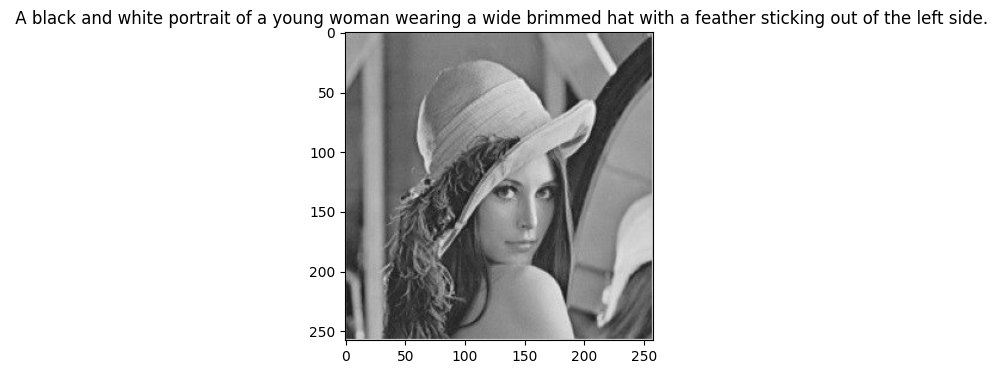

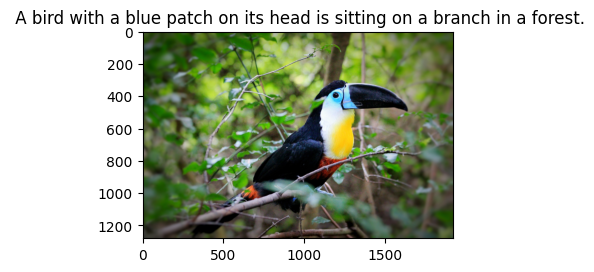

In [1]:
import base64
import json
import requests
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

LLAMA_SERVER_URL = "http://0.0.0.0:8080/v1/chat/completions"

def b64_image(image_path: str) -> str:
    """Convert image to base64 string"""
    data = Path(image_path).read_bytes()
    return base64.b64encode(data).decode("utf-8")

def ask_with_image(image_path: str, question: str):
    """Query VLM with image and question using OpenAI format"""
    payload = {
        "model": "smolvlm",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": question},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{b64_image(image_path)}"}}
                ]
            }
        ],
        "temperature": 0.2,
        "max_tokens": 256
    }
    
    r = requests.post(LLAMA_SERVER_URL, json=payload, timeout=120)
    r.raise_for_status()
    resp = r.json()
    
    # Display image
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(resp["choices"][0]["message"]["content"])

    # Print VLM response
    # print(resp["choices"][0]["message"]["content"])

ask_with_image("images/lena.jpg", "What's in this image? Be concise.")
ask_with_image("images/toucan.jpg", "What's in this image? Be concise.")

## Build the ROS Package

ROS 2 uses the `colcon` build system to compile packages. Before we can run our VLM service node, we need to build the package and set up its dependencies.

The build process installs the Python package, sets up entry points for the executable nodes, and configures the ROS 2 environment.

In [2]:
%%bash
source /opt/ros/kilted/setup.bash

# Build the vlm_ros package
cd /ryzers/notebooks/vlm_ros
colcon build --symlink-install

Starting >>> vlm_ros
Finished <<< vlm_ros [0.54s]

Summary: 1 package finished [0.61s]


## Start the VLM Service Node

Now that the package is built, we can launch the VLM service node. This node will:

1. Subscribe to `/camera/image` topic for incoming images
2. Convert ROS Image messages to OpenCV format using cv_bridge
3. Encode images to base64 and send to llama.cpp server
4. Publish VLM responses to `/vlm/response` topic

**In a separate terminal**, run the VLM service node:

![](images/new_terminal.png)

```bash
source /opt/ros/kilted/setup.bash
source /ryzers/notebooks/vlm_ros/install/setup.bash
ros2 run vlm_ros vlm_service
```

You should see this output:

```
[INFO] [1760575146.024196594] [vlm_service]: VLM Service started, connecting to http://localhost:8080
```

This confirms the node is running and ready to process images.

In [3]:
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import Image
from std_msgs.msg import String
from cv_bridge import CvBridge
import cv2

class VLMTester(Node):
    """Test node to publish images and receive VLM responses"""
    def __init__(self):
        super().__init__('vlm_tester')
        self.image_pub = self.create_publisher(Image, 'camera/image', 10)
        self.response_sub = self.create_subscription(String, 'vlm/response', self.response_callback, 10)
        self.bridge = CvBridge()
        self.latest_response = None
        
    def response_callback(self, msg):
        """Handle incoming VLM responses"""
        self.latest_response = msg.data
        print(f"\nVLM Response: {msg.data}\n")
        
    def publish_test_image(self, image_path):
        """Load and publish an image to the camera topic"""
        img = cv2.imread(image_path)
        if img is None:
            print(f"Could not load image: {image_path}")
            return
            
        msg = self.bridge.cv2_to_imgmsg(img, encoding='bgr8')
        self.image_pub.publish(msg)
        print(f"Published image: {image_path}")

# Initialize ROS
rclpy.init()
tester = VLMTester()
print("VLM tester node initialized")

VLM tester node initialized


## Test with a Sample Image

Now we have a complete pipeline running:
- **llama.cpp server** serving the VLM model
- **vlm_service node** bridging ROS and the VLM
- **vlm_tester node** ready to publish test images

Let's publish a test image and see what the VLM responds with:

In [4]:
# Publish a test image
tester.publish_test_image('images/lena.jpg')

# Spin to receive responses
for _ in range(10):  # Wait up to 5 seconds for response - more relevant for large models
    rclpy.spin_once(tester, timeout_sec=0.5)
    if tester.latest_response:
        break

Published image: images/lena.jpg

VLM Response:  A black and white portrait of a young woman wearing a wide-brimmed hat with a feather sticking out of the top.



## Key Takeaways

Congratulations! You've successfully built a VLM-powered ROS 2 pipeline! You now understand:

* How to run llama.cpp server with vision-language models
* The OpenAI-compatible API format for multimodal requests
* How to integrate VLMs into ROS 2 using publisher-subscriber patterns
* How to bridge between ROS Image messages and base64-encoded images for API calls

## Next Steps

* Experiment with various VLM models to see quality vs. speed tradeoffs, e.g:

```bash
# Smaller, faster model
llama-server -hf ggml-org/SmolVLM-256M-Instruct-GGUF

# Larger, more powerful model
llama-server -hf ggml-org/gemma-3-4b-it-GGUF
```

* Connect a real camera using `v4l2_camera` or `image_tools` packages
* Experiment with different prompts to get better scene descriptions for your use case



---
Copyright© 2025 AMD, Inc SPDX-License-Identifier: MIT